## Libs

In [1]:
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col # statsmodels.iolib.summary2.summary_col
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

pd.set_option('max_colwidth', 500)
warnings.filterwarnings('ignore')
sns.set_style('darkgrid') # darkgrid, darkgrid

## Funcs

In [2]:
def make_df(file_path):
    df = pd.read_csv(file_path, index_col='date', sep=';')
    df['date'] = pd.to_datetime(df.index)
    df.set_index('date', inplace=True)
    df.head()
    return df


def replace_spaces_in_strings(df):
    for col in df.columns:
        if df[col].dtype == 'O':
            df[col] = df[col].str.replace(' ', '').astype('float64')
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('float64')


def scale_series(series, scale=1):
    scaled = series * (1 / scale)
    return scaled


def scale_df(df, thsnds_col=None, mlns_col=None):
    if thsnds_col is not None:
        for col in df[thsnds_col]:
            df[col] = df[col].apply(scale_series, scale=1_000)
    if mlns_col is not None:
        for col in df[mlns_col]:
            df[col] = df[col].apply(scale_series, scale=1_000_000)

def print_data_info(df):
    # Data Summary
    print('Data Shape:', df.shape)
    print('\nData Types:')
    print(df.dtypes)

    # Missing Values Check
    print('\nMissing Values:')
    print(df.isnull().sum())

    # info about dataframe 
    print(df.info())

    # Statistical Summary
    print('\nStatistical Summary:')
    print(df.describe())

    # Adjusting the layout to accommodate all numerical columns
    num_columns = df.select_dtypes(include=['number']).shape[1]

    # Print correlations
    print(df.corr())
    print(sns.heatmap(df.corr()))


    rows = num_columns // 3 + (num_columns % 3 > 0)

    # Histograms for each numerical variable
    df.hist(bins=15, figsize=(15, rows * 5), layout=(rows, 3))
    plt.tight_layout()
    plt.show()


    # Box plots for each numerical variable
    df.plot(kind='box', subplots=True, layout=(rows, 3), figsize=(15, rows * 5), sharex=False, sharey=False)
    plt.tight_layout()
    plt.show()



## Import data

In [3]:
file_path = '../data/data_demo.csv'

df = make_df(file_path)

df.head(3)

,old_sales,sales,price,queries,visits_cost,visits_count,banner_quant,banner_cost,banner_cost_new,context_quant,...,tvr_creative_1,tvr_creative_2,tvr_creative_3,tv_cost,tvr_competitor_1,tvr_competitor_2,tvr_competitor_3,tvr_competitor_4,tvr_competitor_5,tvr_competitor_6
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,102530,95353,143,645354,1508543,2193,0,0,0,9221,...,0,0,0,0,205,397,253,121,249,331
2019-01-07,133632,124278,143,615454,1508543,2193,0,0,0,9221,...,281,0,0,12490514,270,433,202,204,248,319
2019-01-14,135094,125637,143,573170,2724790,3960,0,0,0,9221,...,222,0,0,9835858,228,235,136,206,270,284


## Preprocessing

In [4]:
replace_spaces_in_strings(df)


df['tvr'] = df[[
    'tvr_creative_1', 
    'tvr_creative_2', 
    'tvr_creative_3'
]].sum(axis=1)


scale_df(df,
         thsnds_col=[
            'old_sales',
            'sales',
            'queries',
            'visits_cost',
            'banner_cost',
            'banner_cost_new',
            'olv_cost',
            'olv_cost_new',
            'social_cost',
            'social_cost_new',
            'tv_cost',
         ]
)
# df.describe()[thsnds_col].loc['mean', :]




Data Shape: (170, 29)

Data Types:
old_sales           float64
sales               float64
price               float64
queries             float64
visits_cost         float64
visits_count        float64
banner_quant        float64
banner_cost         float64
banner_cost_new     float64
context_quant       float64
context_cost        float64
context_cost_new    float64
olv_quant           float64
olv_cost            float64
olv_cost_new        float64
social_quant        float64
social_cost         float64
social_cost_new     float64
tvr_creative_1      float64
tvr_creative_2      float64
tvr_creative_3      float64
tv_cost             float64
tvr_competitor_1    float64
tvr_competitor_2    float64
tvr_competitor_3    float64
tvr_competitor_4    float64
tvr_competitor_5    float64
tvr_competitor_6    float64
tvr                 float64
dtype: object

Missing Values:
old_sales           0
sales               0
price               0
queries             0
visits_cost         0
visits_count

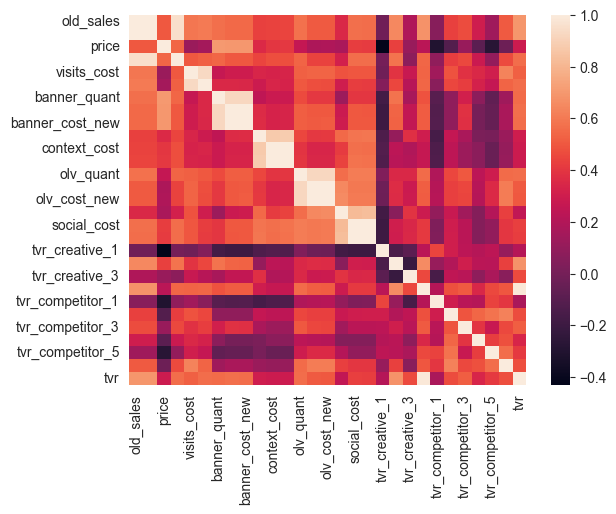

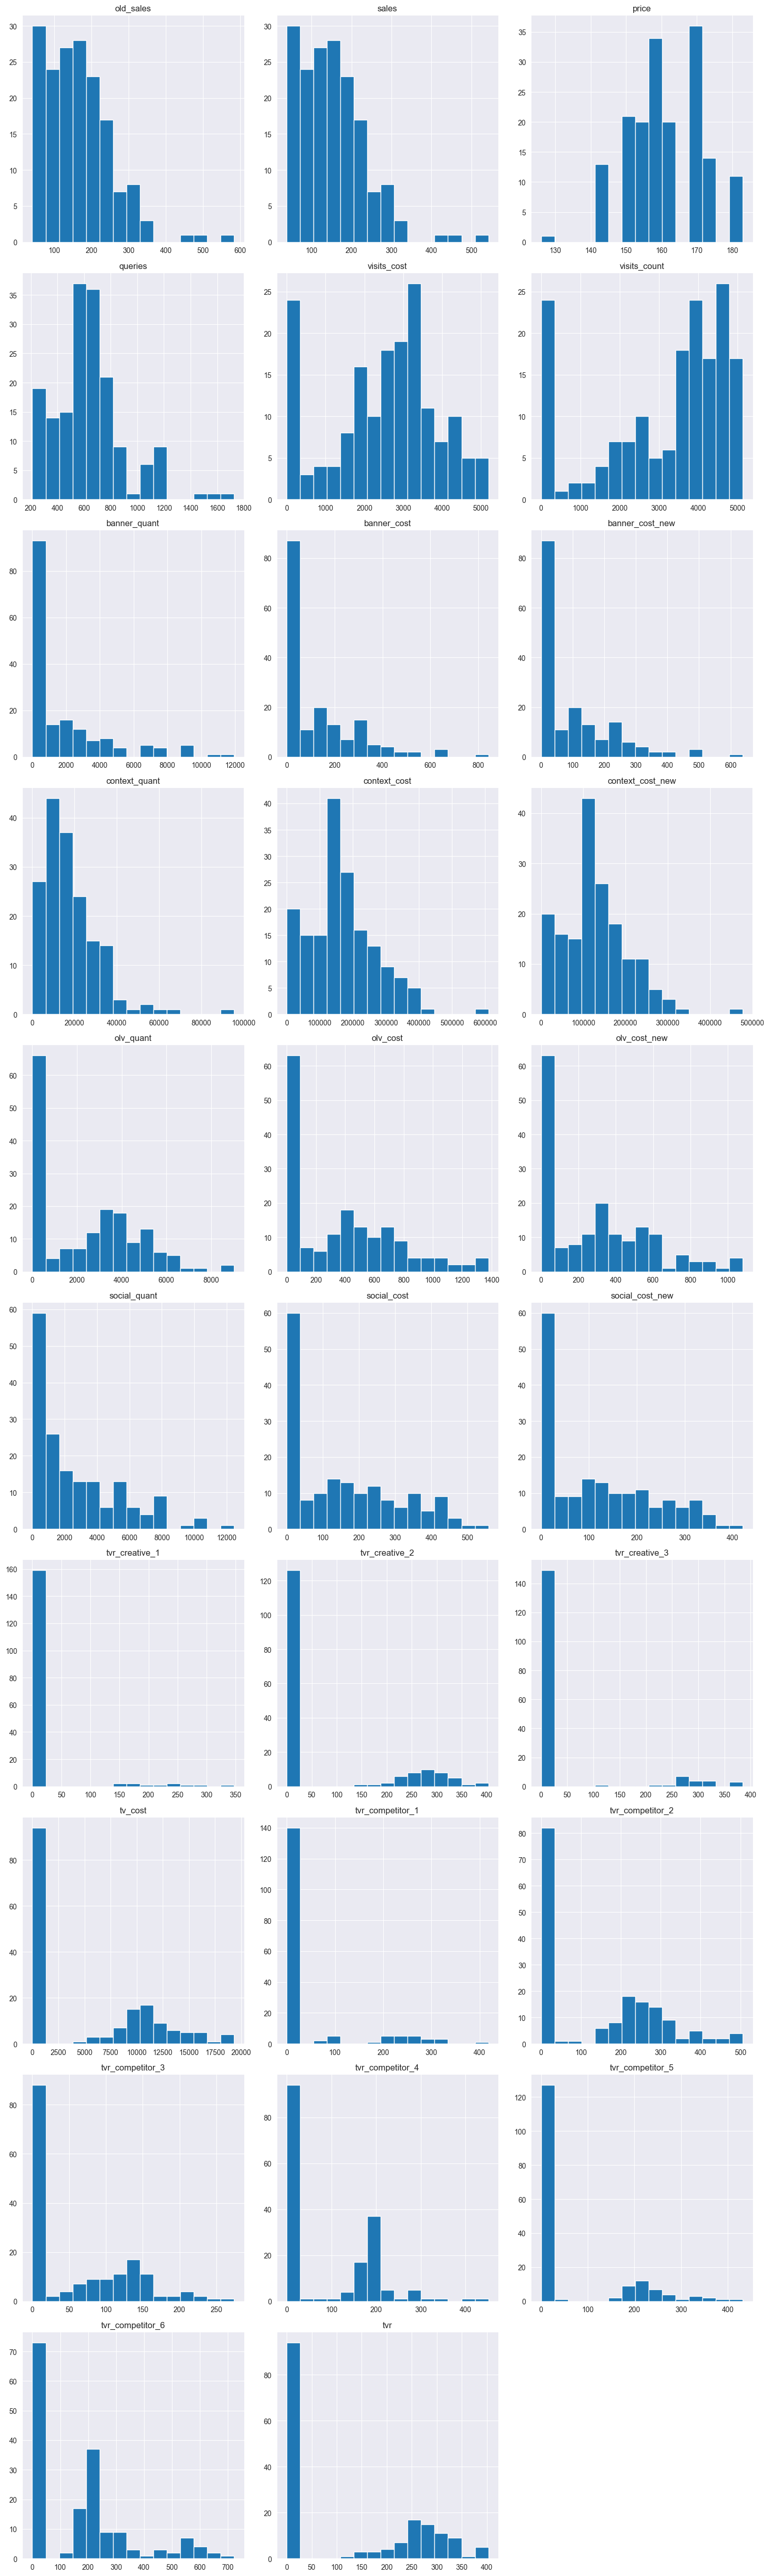

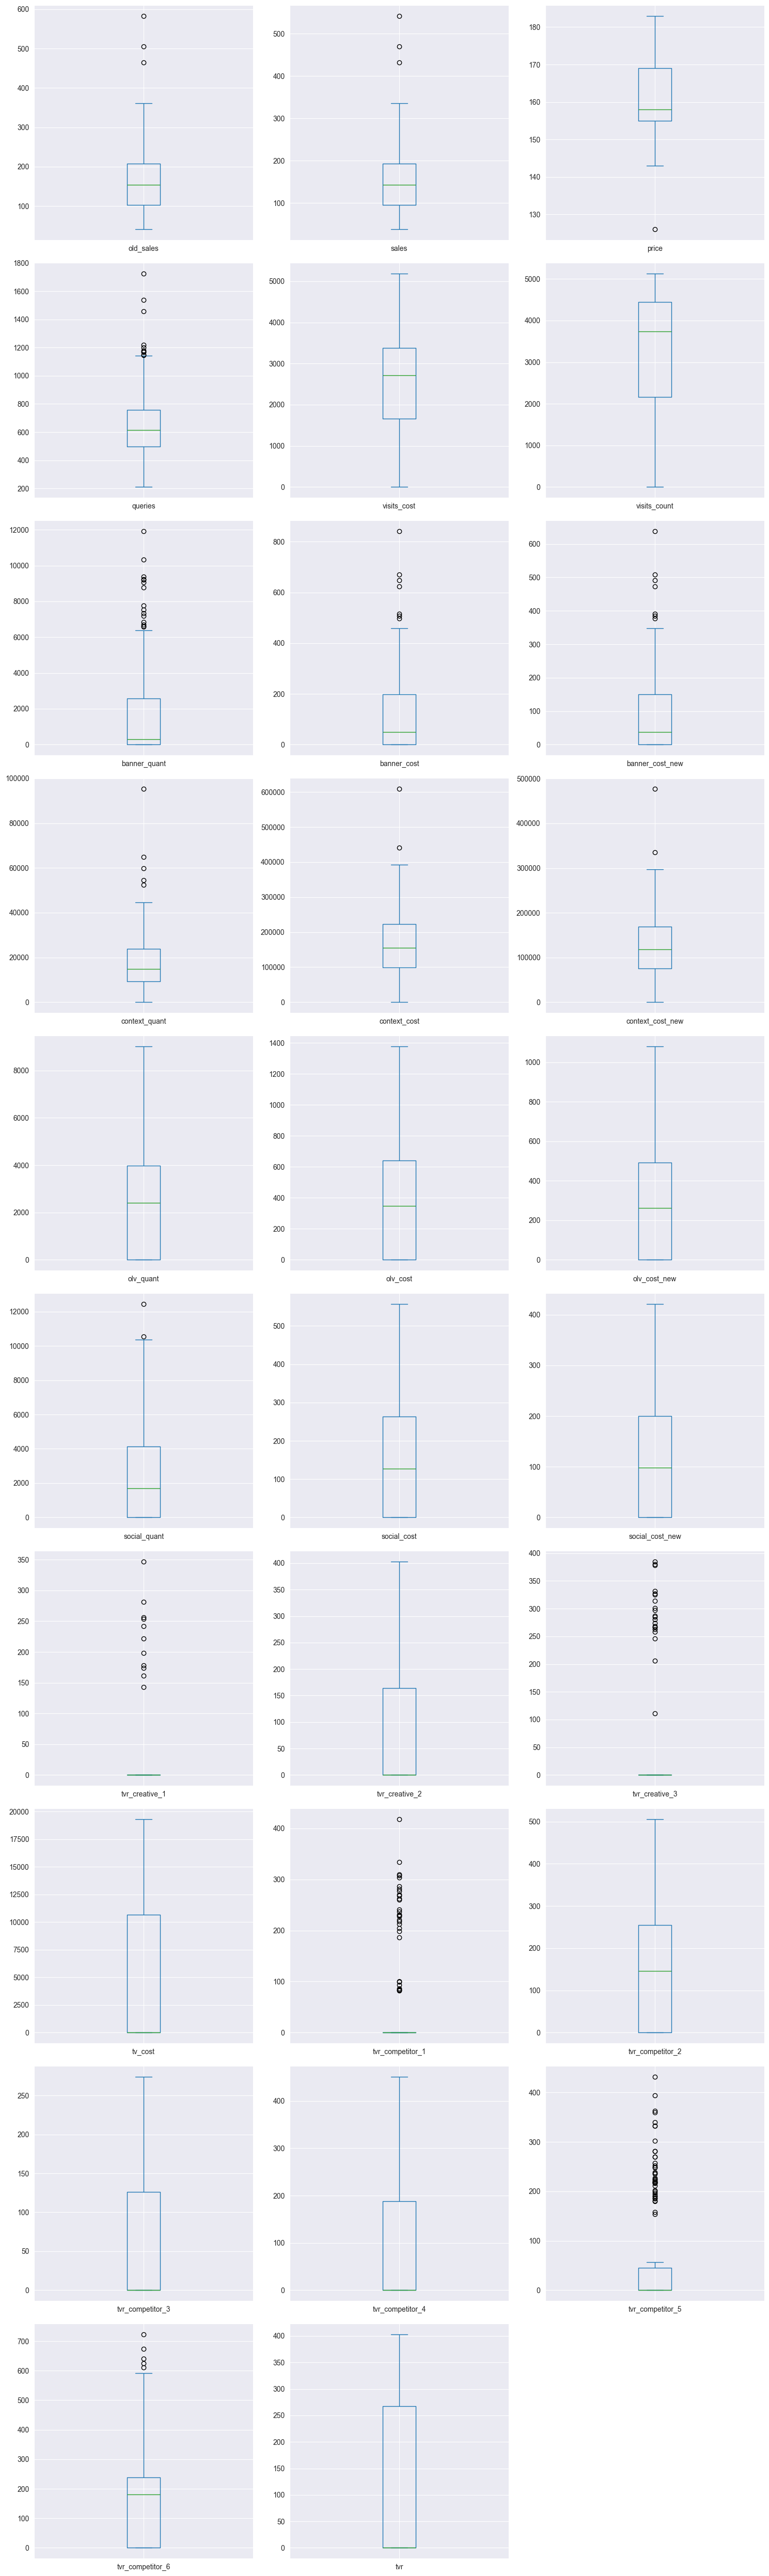

In [5]:
print_data_info(df)

In [6]:
y = df['sales']
X = df.drop(['sales'], axis=1)

## Compare two models

In [7]:
y = df['sales']

X1 = df[['tv_cost', 'olv_cost']]
X1 = sm.add_constant(X1)

X2 = df[['tvr', 'olv_cost']]
X2 = sm.add_constant(X2)

X3 = df[['tv_cost', 'olv_cost', 'visits_cost']]
X3 = sm.add_constant(X3)


models = [
    sm.OLS(y, X1).fit(),
    sm.OLS(y, X2).fit(),
    sm.OLS(y, X3).fit()
]

# Combine summaries into a single dataframe
summary_table = summary_col(models, float_format='%0.4f', stars=True)

# Convert the summary table to a pandas dataframe
summary_df = pd.DataFrame(summary_table.tables[0])

# Print or display the consolidated summary dataframe
summary_df

,sales I,sales II,sales III
R-squared,0.4957,0.5090,0.5430
R-squared Adj.,0.4897,0.5031,0.5348
const,95.8094***,93.9482***,70.0301***
,(6.6499),(6.6032),(8.8883)
olv_cost,0.0457***,0.0458***,0.0245*
,(0.0142),(0.0139),(0.0145)
tv_cost,0.0078***,,0.0064***
,(0.0009),,(0.0009)
tvr,,0.3415***,
,,(0.0367),


In [18]:
m = models[0]
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     82.09
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.49e-25
Time:                        23:05:58   Log-Likelihood:                -932.94
No. Observations:                 170   AIC:                             1872.
Df Residuals:                     167   BIC:                             1881.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.8094      6.650     14.408      0.0

In [27]:
def create_model_metrics(m):    
    model_metrics = {
        'r_adj': [m.rsquared_adj],
        'f_model': [m.f_pvalue], 
    }

    # return pd.DataFrame(model_metrics)
    return model_metrics

res = create_model_metrics(m)
res

{'r_adj': [0.4896929471460445], 'f_model': [1.4866942329652624e-25]}

In [97]:
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     82.09
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           1.49e-25
Time:                        23:37:11   Log-Likelihood:                -932.94
No. Observations:                 170   AIC:                             1872.
Df Residuals:                     167   BIC:                             1881.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.8094      6.650     14.408      0.0

In [203]:
def create_models_metrics(models, y, n_digits=3):

    def round_values(d):
        for k, v in d.items():
            d[k] = round(v, n_digits)
        return str(d)

    models_metrics = {
        'model_number': [],
        'r2_adj': [],
        'r2_simple': [],
        'f_model': [],
        'f_model_pvalue': [],
        'dw': [],
        'mape': [],
        'aic': [],
        'bic': [],
        'nobs': [],
        'factors': [],
        'factors_p': [],
        'model': [],
    }
    
    for m in models:
        models_metrics['model_number'].append(models.index(m))
        models_metrics['r2_adj'].append(round(m.rsquared_adj, n_digits))
        models_metrics['r2_simple'].append(round(m.rsquared, n_digits))
        models_metrics['f_model'].append(round(m.fvalue, n_digits))
        models_metrics['f_model_pvalue'].append(round(m.f_pvalue, n_digits))
        models_metrics['dw'].append(round(sm.stats.stattools.durbin_watson(m.resid, axis=0), n_digits))
        models_metrics['aic'].append(round(m.aic, 0))
        models_metrics['bic'].append(round(m.bic, 0))
        models_metrics['mape'].append(round(mean_absolute_percentage_error(m.fittedvalues.values, y), n_digits))
        models_metrics['nobs'].append(m.nobs)
        
        models_metrics['factors'].append(round_values(m.params.to_dict()))
        models_metrics['factors_p'].append(round_values(m.pvalues.to_dict()))

        models_metrics['model'].append(m)
    
    return pd.DataFrame(data=models_metrics)


res = create_models_metrics(models, y)
res

,model_number,r2_adj,r2_simple,f_model,f_model_pvalue,dw,mape,aic,bic,nobs,factors,factors_p,model
0,0,0.490,0.496,82.087,0.0,0.415,0.277,1872.0,1881.0,170.0,"{'const': 95.809, 'tv_cost': 0.008, 'olv_cost': 0.046}","{'const': 0.0, 'tv_cost': 0.0, 'olv_cost': 0.002}",<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x10b914790>
1,1,0.503,0.509,86.556,0.0,0.426,0.275,1867.0,1877.0,170.0,"{'const': 93.948, 'tvr': 0.341, 'olv_cost': 0.046}","{'const': 0.0, 'tvr': 0.0, 'olv_cost': 0.001}",<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x10b859b20>
2,2,0.535,0.543,65.752,0.0,0.462,0.261,1857.0,1870.0,170.0,"{'const': 70.03, 'tv_cost': 0.006, 'olv_cost': 0.024, 'visits_cost': 0.016}","{'const': 0.0, 'tv_cost': 0.0, 'olv_cost': 0.093, 'visits_cost': 0.0}",<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x10b8c1af0>


<Axes: >

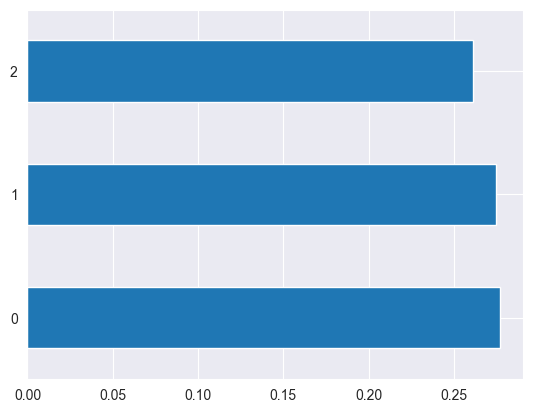

In [187]:
res['mape'].plot(kind='barh')

In [194]:
pd.DataFrame({
    'params': round(m.params, 3),
    'pvalues': round(m.pvalues, 3), 
    
})

,params,pvalues
const,95.809,0.000
tv_cost,0.008,0.000
olv_cost,0.046,0.002


In [207]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [236]:
df_m = pd.DataFrame()

df_m['variable'] = X1.columns
df_m['VIF'] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
df_m['params'] = m.params.values
df_m['pvalues'] = m.pvalues.values
df_m['model_number'] = 1 

df_m

,variable,VIF,params,pvalues,model_number
0,const,2.158327,95.809402,4.184964e-31,1
1,tv_cost,1.366961,0.007751,7.001461e-16,1
2,olv_cost,1.366961,0.045719,1.553543e-03,1


In [225]:
X2.columns

Index(['const', 'tvr', 'olv_cost'], dtype='object')

In [234]:
m2 = models[2]

df_m2 = pd.DataFrame()
df_m2['variable'] = X3.columns
df_m2['VIF'] = [variance_inflation_factor(X3.values, i) for i in range(X3.shape[1])]
df_m2['params'] = m2.params.values
df_m2['pvalues'] = m2.pvalues.values
df_m2['model_number'] = 2

df_m2

,variable,VIF,params,pvalues,model_number
0,const,4.229466,70.030112,4.123792e-13,2
1,tv_cost,1.566131,0.006441,1.342021e-11,2
2,olv_cost,1.562189,0.024467,9.349486e-02,2
3,visits_cost,1.598734,0.016315,5.412998e-05,2


In [235]:
pd.concat([df_m, df_m2])

,variable,VIF,params,pvalues,model_number
0,const,2.158327,95.809402,4.184964e-31,1
1,tv_cost,1.366961,0.007751,7.001461e-16,1
2,olv_cost,1.366961,0.045719,1.553543e-03,1
0,const,4.229466,70.030112,4.123792e-13,2
1,tv_cost,1.566131,0.006441,1.342021e-11,2
2,olv_cost,1.562189,0.024467,9.349486e-02,2
3,visits_cost,1.598734,0.016315,5.412998e-05,2


## Building range of models

### Models initialization

In [353]:

# used: 
    # df - global
    # y - global
    # X1 - list of vars in dataframe df 
    # model is build on X1
    # model number (1, 2, 3 etc )


# model_config_manual = {
#     '1': [], 
#     '2': [], 
#     '3': []
# }



In [350]:
import time


def create_factors_combinations(factors_list):
    '''
    Length of factors list should be less then 7, as it is factorial complexity.
    '''
    
    res = []
    for i in range(len(factors_list)):
        temp = list(itertools.combinations(factors_list, i + 1))
        res += temp
    return [list(item) for item in res]


def build_models(df, kpi_name, factors_list=[], is_constant=True, n_digits=3):

    if kpi_name == '':
        print('No KPI. Please, include')
        return

    if factors_list == []:
        print('No factors. Please, include')
        return
    
    start_time = time.time()
    print('Start building')

    y = df[kpi_name]

    factors_combinations = create_factors_combinations(factors_list)
    
    blank_res = pd.DataFrame(
        columns = [
            'variable',
            'vif', 
            'beta',
            'beta_pvalue',
            'model_number',
            'r2_adj',
            'r2',
            'dw',
            'mape',
            'f_model',
            'f_model_pvalue',
            'aic',
            'bic',
            'model',
        ]
    )
    main_res = blank_res.copy()
    model_number = 1
    for factor_combination in factors_combinations:
        X = df[factor_combination]
        if is_constant:
            X = sm.add_constant(X)
        model_ols = sm.OLS(y, X).fit()
        
        temp = blank_res.copy()
        temp['variable'] = X.columns
        temp['vif'] = np.round([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], n_digits)
        temp['beta'] = np.round(model_ols.params.values, n_digits)
        temp['beta_pvalue'] = np.round(model_ols.pvalues.values, n_digits)
        temp['model_number'] = model_number
        temp['r2_adj'] = np.round(model_ols.rsquared_adj, n_digits)
        temp['r2'] = np.round(model_ols.rsquared, n_digits)
        temp['dw'] = np.round(sm.stats.stattools.durbin_watson(model_ols.resid, axis=0), n_digits)
        temp['mape'] = np.round(mean_absolute_percentage_error(model_ols.fittedvalues.values, y), n_digits)
        temp['f_model'] = np.round(model_ols.fvalue, n_digits)
        temp['f_model_pvalue'] = np.round(model_ols.f_pvalue, n_digits)
        
        temp['aic'] = np.round(model_ols.aic, n_digits)
        temp['bic'] = np.round(model_ols.bic, n_digits)

        temp['model'] = model_ols

        
        main_res = pd.concat([main_res, temp])
        model_number = model_number + 1

    main_res.reset_index(inplace=True)
    main_res.drop('index', axis=1, inplace=True)
    print(f"End building. Execition time: {(time.time() - start_time)} seconds")
    return main_res


def extract_model(models, model_number):
    return models[models['model_number'] == model_number].iloc[0]['model']




factors_list = ['tv_cost', 'olv_cost', 'visits_cost']
models = build_models(
    df, 
    kpi_name='sales', 
    factors_list=['tv_cost', 'olv_cost', 'visits_cost']
)

best_model = extract_model(models, 7)

models.sort_values(by=['mape', 'r2_adj'])

Start building
End building. Execition time: 0.05897331237792969 seconds


,variable,vif,beta,beta_pvalue,model_number,r2_adj,r2,dw,mape,f_model,f_model_pvalue,aic,bic,model
15,const,4.229,70.030,0.000,7,0.535,0.543,0.462,0.261,65.752,0.0,1857.134,1869.677,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bbb0>
16,tv_cost,1.566,0.006,0.000,7,0.535,0.543,0.462,0.261,65.752,0.0,1857.134,1869.677,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bbb0>
17,olv_cost,1.562,0.024,0.093,7,0.535,0.543,0.462,0.261,65.752,0.0,1857.134,1869.677,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bbb0>
18,visits_cost,1.599,0.016,0.000,7,0.535,0.543,0.462,0.261,65.752,0.0,1857.134,1869.677,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bbb0>
9,const,4.215,70.895,0.000,5,0.530,0.535,0.501,0.276,96.143,0.0,1858.024,1867.431,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15b400>
10,tv_cost,1.399,0.007,0.000,5,0.530,0.535,0.501,0.276,96.143,0.0,1858.024,1867.431,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15b400>
11,visits_cost,1.399,0.019,0.000,5,0.530,0.535,0.501,0.276,96.143,0.0,1858.024,1867.431,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15b400>
6,const,2.158,95.809,0.000,4,0.490,0.496,0.415,0.277,82.087,0.0,1871.874,1881.282,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bee0>
7,tv_cost,1.367,0.008,0.000,4,0.490,0.496,0.415,0.277,82.087,0.0,1871.874,1881.282,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bee0>
8,olv_cost,1.367,0.046,0.002,4,0.490,0.496,0.415,0.277,82.087,0.0,1871.874,1881.282,<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x13a15bee0>


## Testing large combinations of factors

In [237]:
factors_list = ['tv_cost', 'olv_cost', 'visits_cost']

In [239]:
import itertools

In [245]:
list(itertools.combinations_with_replacement(factors_list, 3))

[('tv_cost', 'tv_cost', 'tv_cost'),
 ('tv_cost', 'tv_cost', 'olv_cost'),
 ('tv_cost', 'tv_cost', 'visits_cost'),
 ('tv_cost', 'olv_cost', 'olv_cost'),
 ('tv_cost', 'olv_cost', 'visits_cost'),
 ('tv_cost', 'visits_cost', 'visits_cost'),
 ('olv_cost', 'olv_cost', 'olv_cost'),
 ('olv_cost', 'olv_cost', 'visits_cost'),
 ('olv_cost', 'visits_cost', 'visits_cost'),
 ('visits_cost', 'visits_cost', 'visits_cost')]

In [258]:
a = list(itertools.combinations(factors_list, 1))

In [259]:
b = list(itertools.combinations(factors_list, 2))

In [260]:
c = list(itertools.combinations(factors_list, 3))

In [267]:
# import math

math.factorial(7)

5040

In [261]:
d = a + b + c
d

[('tv_cost',),
 ('olv_cost',),
 ('visits_cost',),
 ('tv_cost', 'olv_cost'),
 ('tv_cost', 'visits_cost'),
 ('olv_cost', 'visits_cost'),
 ('tv_cost', 'olv_cost', 'visits_cost')]

In [268]:
for item in d:
    print(list(item))

['tv_cost']
['olv_cost']
['visits_cost']
['tv_cost', 'olv_cost']
['tv_cost', 'visits_cost']
['olv_cost', 'visits_cost']
['tv_cost', 'olv_cost', 'visits_cost']


In [277]:
def create_factors_combinations(factors):
    res = []
    for i in range(len(factors)):
        temp = list(itertools.combinations(factors, i + 1))
        res += temp
    res = [list(item) for item in res]
    return res

create_factors_combinations(factors_list)

[['tv_cost'],
 ['olv_cost'],
 ['visits_cost'],
 ['tv_cost', 'olv_cost'],
 ['tv_cost', 'visits_cost'],
 ['olv_cost', 'visits_cost'],
 ['tv_cost', 'olv_cost', 'visits_cost']]

In [249]:
list(itertools.permutations(factors_list))

[('tv_cost', 'olv_cost', 'visits_cost'),
 ('tv_cost', 'visits_cost', 'olv_cost'),
 ('olv_cost', 'tv_cost', 'visits_cost'),
 ('olv_cost', 'visits_cost', 'tv_cost'),
 ('visits_cost', 'tv_cost', 'olv_cost'),
 ('visits_cost', 'olv_cost', 'tv_cost')]

In [140]:
from sklearn.metrics import mean_absolute_percentage_error

In [152]:
round(mean_absolute_percentage_error(m.fittedvalues.values, y), 3)

0.277

In [156]:
m.pvalues

const       4.184964e-31
tv_cost     7.001461e-16
olv_cost    1.553543e-03
dtype: float64

In [139]:
m.params

const       95.809402
tv_cost      0.007751
olv_cost     0.045719
dtype: float64

In [72]:
str(m.params.to_dict())

"{'const': 95.80940232308913, 'tv_cost': 0.007750659980180253, 'olv_cost': 0.045718642766983536}"

In [75]:
d = m.params.to_dict()
d

{'const': 95.80940232308913,
 'tv_cost': 0.007750659980180253,
 'olv_cost': 0.045718642766983536}

In [84]:
for k, v in d.items():
    d[k] = round(v, 3)

print(d)

{'const': 95.809, 'tv_cost': 0.008, 'olv_cost': 0.046}


In [80]:
round(3.12313, 3)

3.123

## Seasonality Extraction

### STL extraction trend, seasonality

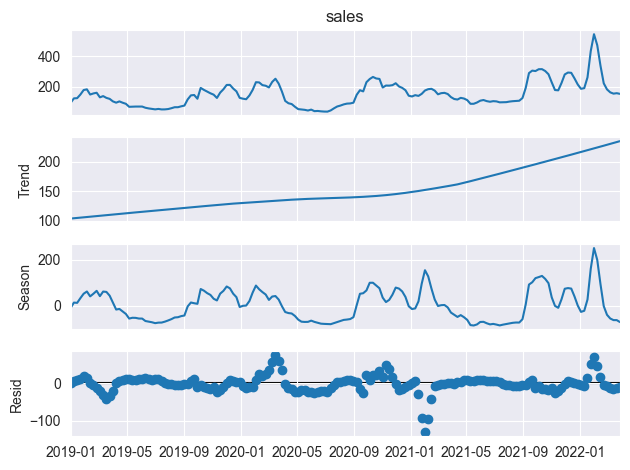

In [9]:
# from statsmodels.tsa.seasonal import STL
model_stl = STL(y).fit()
model_stl.plot()
plt.show()b

In [41]:
def decompose_stl(y):
    model = STL(y).fit()
    df_timeseries = pd.DataFrame(y)
    df_timeseries['residuals'] = model.resid
    df_timeseries['trend'] = model.trend
    df_timeseries['seasonality'] = model.seasonal
    return df_timeseries

In [42]:
df_stl = decompose_stl(y)

### Create new dates for continuining trend and seasonality pattern (very basic scenario)

In [53]:
future_dates = pd.date_range(start='2022-04-04', periods=12, freq='W')

future_X = pd.DataFrame(index=future_dates, columns=df_timeseries.columns)

future_X['res_stl_trend'] = model_stl.trend[-1]  # Assuming trend continues
future_X['res_stl_seasonal'] = np.tile(model_stl.seasonal.tail(7).values, 2)[:12]  # Use the last observed seasonal pattern
future_X['res_stl_resid'] = 0  # Assuming no residual for simplicity

future_X

,res_stl_resid,res_stl_trend,res_stl_seasonal
2022-04-10,0,234.689269,93.824363
2022-04-17,0,234.689269,-1.018038
2022-04-24,0,234.689269,-38.598230
2022-05-01,0,234.689269,-54.610749
2022-05-08,0,234.689269,-61.518036
2022-05-15,0,234.689269,-61.615357
2022-05-22,0,234.689269,-70.158990
2022-05-29,0,234.689269,93.824363
2022-06-05,0,234.689269,-1.018038
2022-06-12,0,234.689269,-38.598230


In [58]:
# Extrapolate the trend into the future using the last observed slope

last_observed_slope = model_stl.trend.diff().iloc[-1]
future_X['trend_2'] = model_stl.trend[-1] + np.arange(1, 13) * last_observed_slope


In [61]:
last_observed_slope

1.5501334009899495

In [63]:
np.arange(1, 13) * last_observed_slope

array([ 1.5501334 ,  3.1002668 ,  4.6504002 ,  6.2005336 ,  7.750667  ,
        9.30080041, 10.85093381, 12.40106721, 13.95120061, 15.50133401,
       17.05146741, 18.60160081])

In [65]:
future_X['trend_3'] = model_stl.trend[-1] + 1 * last_observed_slope

In [68]:
future_X

,res_stl_resid,res_stl_trend,res_stl_seasonal,trend_2,trend_3
2022-04-10,0,234.689269,93.824363,236.239402,236.239402
2022-04-17,0,234.689269,-1.018038,237.789536,236.239402
2022-04-24,0,234.689269,-38.598230,239.339669,236.239402
2022-05-01,0,234.689269,-54.610749,240.889803,236.239402
2022-05-08,0,234.689269,-61.518036,242.439936,236.239402
2022-05-15,0,234.689269,-61.615357,243.990069,236.239402
2022-05-22,0,234.689269,-70.158990,245.540203,236.239402
2022-05-29,0,234.689269,93.824363,247.090336,236.239402
2022-06-05,0,234.689269,-1.018038,248.640470,236.239402
2022-06-12,0,234.689269,-38.598230,250.190603,236.239402


## To Do

### Add trend and seasonality into dataframe

In [44]:
X = X.join(df_stl, how='left', on=X.index)
X.head()

,old_sales,price,queries,visits_cost,visits_count,banner_quant,banner_cost,banner_cost_new,context_quant,context_cost,...,tvr_competitor_2,tvr_competitor_3,tvr_competitor_4,tvr_competitor_5,tvr_competitor_6,tvr,sales,residuals,trend,seasonality
date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,102.530,143.0,645.354,1508.543,2193.0,0.0,0.0,0.0,9221.0,44533.0,...,397.0,253.0,121.0,249.0,331.0,0.0,95.353,0.703942,103.436534,-8.787476
2019-01-07,133.632,143.0,615.454,1508.543,2193.0,0.0,0.0,0.0,9221.0,44533.0,...,433.0,202.0,204.0,248.0,319.0,281.0,124.278,5.943917,103.966984,14.367099
2019-01-14,135.094,143.0,573.170,2724.790,3960.0,0.0,0.0,0.0,9221.0,44533.0,...,235.0,136.0,206.0,270.0,284.0,222.0,125.637,7.914803,104.497032,13.225165
2019-01-21,160.531,143.0,661.720,2646.358,3846.0,0.0,0.0,0.0,9221.0,44533.0,...,335.0,75.0,168.0,340.0,305.0,198.0,149.294,10.610880,105.026635,33.656485
2019-01-28,192.127,143.0,764.809,2456.814,3571.0,0.0,0.0,0.0,9221.0,44533.0,...,207.0,0.0,353.0,57.0,212.0,242.0,178.678,20.341403,105.555729,52.780868


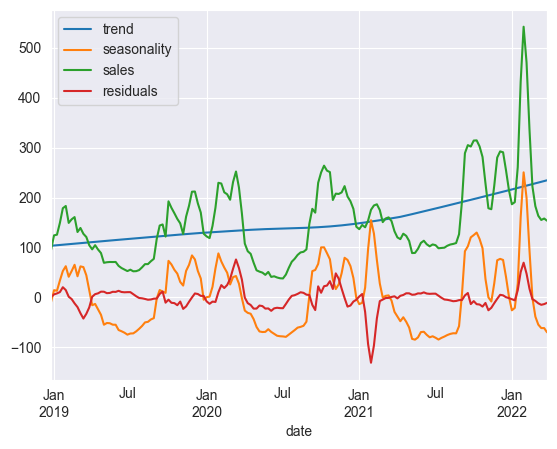

In [46]:
X[[
    'trend',
    'seasonality',
    'sales',
    'residuals'
]].plot()
plt.show()

In [34]:
X1 = X[[
    'tv_cost', 
    'olv_cost'
]]
X1 = sm.add_constant(X1)

X2 = X[[
    'tv_cost', 
    'olv_cost', 
    'trend', 
    'season'
]]
X2 = sm.add_constant(X2)

X3 = X[[
    'tv_cost', 
    'olv_cost', 
    'trend', 
    # 'season'
]]
X3 = sm.add_constant(X3)


models = [
    sm.OLS(y, X1).fit(),
    sm.OLS(y, X2).fit(),
    sm.OLS(y, X3).fit(),
]

# Combine summaries into a single dataframe
summary_table = summary_col(models, float_format='%0.4f', stars=True)

# Convert the summary table to a pandas dataframe
summary_df = pd.DataFrame(summary_table.tables[0])

# Print or display the consolidated summary dataframe
summary_df

,sales I,sales II,sales III
R-squared,0.4957,0.9224,0.6382
R-squared Adj.,0.4897,0.9205,0.6316
const,95.8094***,-2.3502,-35.2470**
,(6.6499),(8.0883),(17.1696)
olv_cost,0.0457***,-0.0001,0.0459***
,(0.0142),(0.0059),(0.0121)
season,,0.9446***,
,,(0.0384),
trend,,0.9749***,0.9097***
,,(0.0524),(0.1125)


### Forecasting trend and seasonality with ARIMA

### Extract and forecast trend, seasonality with Prophet

In [47]:
from prophet import Prophet

In [133]:
def decompose_prophet_basic(df, y, multi=False, future_periods=0):
    '''
    df - full df with date in index
    y - target metric
    '''
    temp = df[[y]]
    temp.reset_index(inplace=True)
    temp.columns = ['ds', 'y']

    if multi:
        model = Prophet(seasonality_mode='multiplicative')
    
    else:
        model = Prophet(seasonality_mode='additive')
    
    model.fit(temp)
    future = model.make_future_dataframe(future_periods)
    forecast = model.predict(future)

    df_prophet_extracted = forecast.copy()
    df_prophet_extracted.index = df_prophet_extracted['ds']

    return df_prophet_extracted

In [134]:
test_df = decompose_prophet_basic(df, 'sales', multi=True)
test_df.head()

23:39:02 - cmdstanpy - INFO - Chain [1] start processing
23:39:02 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2018-12-31,2018-12-31,106.866892,63.160259,144.380837,106.866892,106.866892,-0.043645,-0.043645,-0.043645,-0.043645,-0.043645,-0.043645,0.0,0.0,0.0,102.202684
2019-01-07,2019-01-07,107.243137,57.710922,135.581260,107.243137,107.243137,-0.105808,-0.105808,-0.105808,-0.105808,-0.105808,-0.105808,0.0,0.0,0.0,95.895925
2019-01-14,2019-01-14,107.619381,72.058236,157.487004,107.619381,107.619381,0.065505,0.065505,0.065505,0.065505,0.065505,0.065505,0.0,0.0,0.0,114.668964
2019-01-21,2019-01-21,107.995625,112.323484,197.743461,107.995625,107.995625,0.432380,0.432380,0.432380,0.432380,0.432380,0.432380,0.0,0.0,0.0,154.690794
2019-01-28,2019-01-28,108.371870,152.774791,231.387362,108.371870,108.371870,0.794566,0.794566,0.794566,0.794566,0.794566,0.794566,0.0,0.0,0.0,194.480420


In [ ]:
test_df

In [135]:
! pwd

/Users/ivan/Yandex.Disk.localized/work_yadisk/mmm_tools/notebooks


In [77]:
df_prophet = df[['sales']]
df_prophet.reset_index(inplace=True)
df_prophet.columns = ['ds', 'y']

23:13:32 - cmdstanpy - INFO - Chain [1] start processing
23:13:32 - cmdstanpy - INFO - Chain [1] done processing


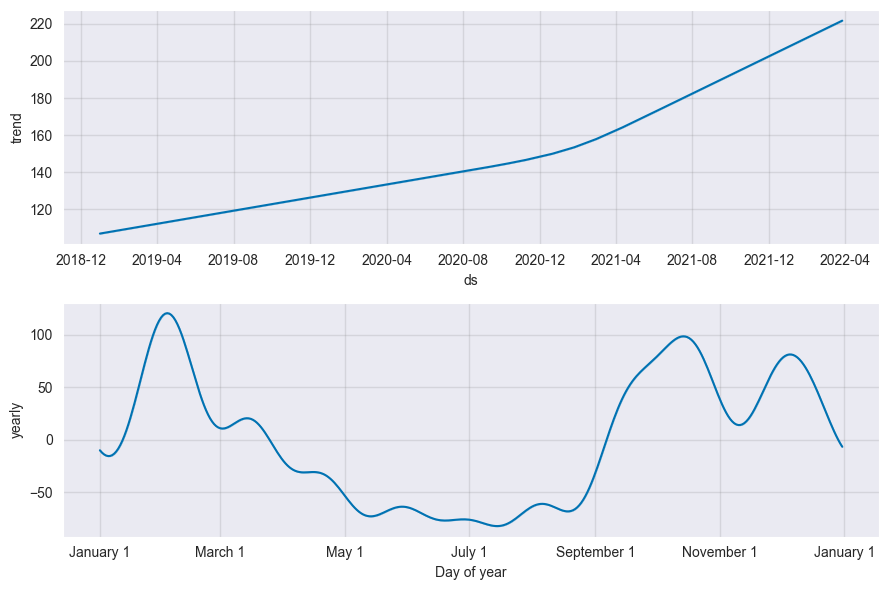

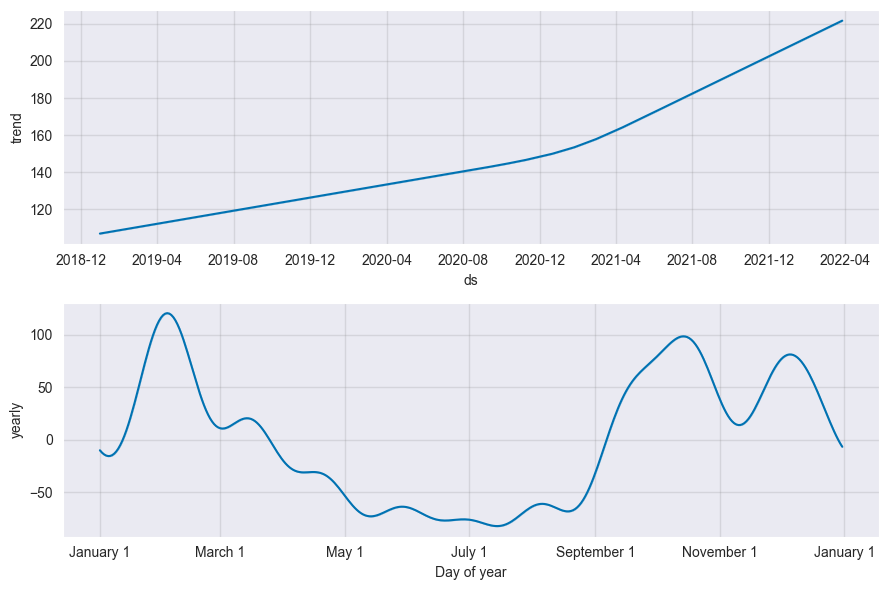

In [112]:
m = Prophet(
    yearly_seasonality=True,
    # weekly_seasonality=True,
    # daily_seasonality=True, 
    # seasonality_mode='multiplicative'
)
m.fit(df_prophet)


future = m.make_future_dataframe(0)
forecast = m.predict(future)
df_prophet_extracted = forecast.copy()
df_prophet_extracted.index = df_prophet_extracted['ds']
# df_prophet_extracted.head()

m.plot_components(forecast)


In [113]:
# df_prophet_extracted.head()

In [114]:
df_stl_vs_prophet = df_stl.join(df_prophet_extracted[['trend', 'yearly']], how='left', on=df_prophet_extracted.index, lsuffix='_stl')
df_stl_vs_prophet.rename(
    columns={
        'trend': 'trend_prophet',
        'yearly': 'seasonality_prophet',
        'seasonality': 'seasonality_stl'
    }, 
    inplace=True
)
df_stl_vs_prophet.head()

,sales,residuals,trend_stl,seasonality_stl,trend_prophet,seasonality_prophet
date,,,,,,
2018-12-31,95.353,0.703942,103.436534,-8.787476,106.996537,-5.942444
2019-01-07,124.278,5.943917,103.966984,14.367099,107.401075,-15.225366
2019-01-14,125.637,7.914803,104.497032,13.225165,107.805613,6.299299
2019-01-21,149.294,10.610880,105.026635,33.656485,108.210151,53.836540
2019-01-28,178.678,20.341403,105.555729,52.780868,108.614689,102.209193


<Axes: xlabel='date'>

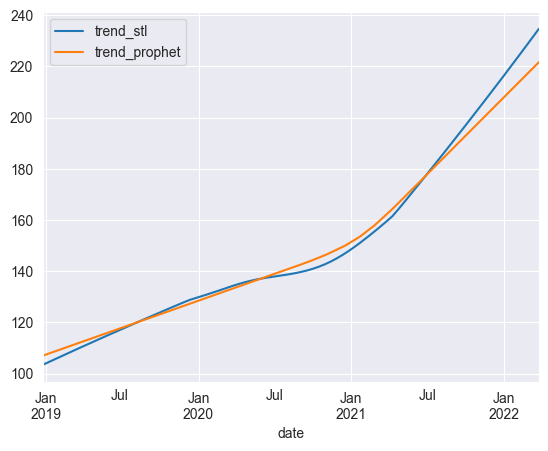

In [115]:
df_stl_vs_prophet[[
    'trend_stl',
    # 'seasonality_stl',
    'trend_prophet',
    # 'seasonality_prophet'
]].plot()

<Axes: xlabel='date'>

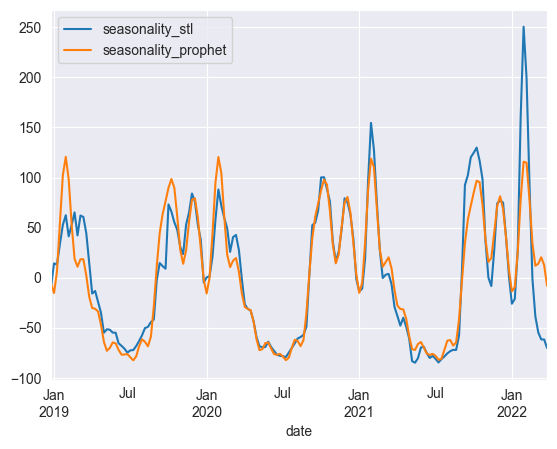

In [118]:
df_stl_vs_prophet[[
    # 'trend_stl',
    'seasonality_stl',
    # 'trend_prophet',
    'seasonality_prophet',
    # 'sales'
]].plot()

In [120]:
from sklearn.metrics import mean_absolute_percentage_error

In [122]:
df_stl_vs_prophet['trend_seasonality_stl'] = df_stl_vs_prophet['trend_stl'] + df_stl_vs_prophet['seasonality_stl']
df_stl_vs_prophet['trend_seasonality_prophet'] = df_stl_vs_prophet['trend_prophet'] + df_stl_vs_prophet['seasonality_prophet']


print(
    mean_absolute_percentage_error(df_stl_vs_prophet['sales'], df_stl_vs_prophet['trend_seasonality_stl'])
)

print(
    mean_absolute_percentage_error(df_stl_vs_prophet['sales'], df_stl_vs_prophet['trend_seasonality_prophet'])
)

0.11816141029278612
0.17377423816094967


<Axes: xlabel='date'>

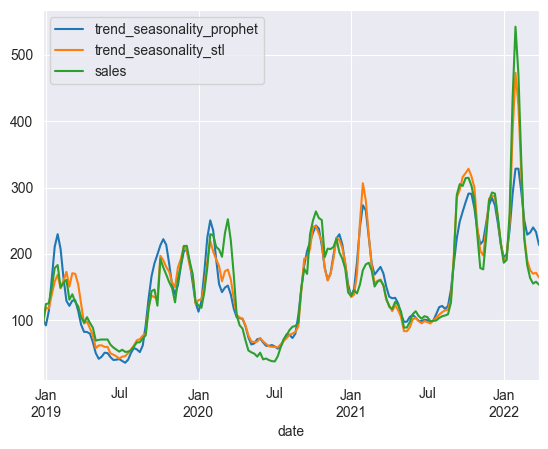

In [123]:
df_stl_vs_prophet[[
    'trend_seasonality_prophet',
    'trend_seasonality_stl',
    'sales'
]].plot()

### Extract and forecast trend, seasonality with oter tool